### Exercise 1

The following cell sets up some functions and pulls in data for the first few exercises.  In the first exercise we'll explore the interaction of different dimensionality reduction strategies with k-means.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the MNIST digit data
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualization function
def visualize_clusters(X_2D, labels, title=""):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='tab10', s=50, alpha=0.6, edgecolors='w')
    plt.title(title)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.colorbar(scatter)
    plt.show()



#### Step 1: Helper function for k-means evaluation

Build a function that takes some data, a min k-value, a max k value, and a title that plots three graphs showing davies-bouldin, silhouette, and inertia (elbow) for k-means. Once you're done, run the function on the raw data to establish a baseline.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def plot_kmeans_diagnostics(
    X,
    k_min: int,
    k_max: int,
    title: str = "",
    random_state: int = 42,
    n_init: int = 10,
    max_iter: int = 300,
    figsize=(15, 4),
):
    """
    Plot Davies-Bouldin (min better), Silhouette (max better), and Inertia (elbow) for KMeans.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Data matrix.
    k_min, k_max : int
        Inclusive range of K to evaluate (k_min >= 1).
    title : str
        Title for the figure.
    random_state : int
        Random seed for reproducibility.
    n_init : int
        Number of KMeans initializations.
    max_iter : int
        Max iterations for KMeans.
    figsize : tuple
        Matplotlib figure size.

    Returns
    -------
    scores_df : pandas.DataFrame
        Columns: ['k', 'inertia', 'silhouette', 'davies_bouldin']
    """
    if k_min < 1:
        raise ValueError("k_min must be >= 1")
    if k_max < k_min:
        raise ValueError("k_max must be >= k_min")

    ks = list(range(k_min, k_max + 1))
    inertia_vals = []
    sil_vals = []
    db_vals = []

    for k in ks:
        km = KMeans(
            n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=random_state
        )
        labels = km.fit_predict(X)
        inertia_vals.append(km.inertia_)

        # Silhouette & DB are undefined for k=1; store NaN in that case
        if k >= 2:
            sil_vals.append(silhouette_score(X, labels, metric="euclidean"))
            db_vals.append(davies_bouldin_score(X, labels))
        else:
            sil_vals.append(np.nan)
            db_vals.append(np.nan)

    scores_df = pd.DataFrame(
        {
            "k": ks,
            "inertia": inertia_vals,
            "silhouette": sil_vals,
            "davies_bouldin": db_vals,
        }
    )

    # Identify best Ks (ignoring NaNs)
    k_best_sil = scores_df.loc[scores_df["silhouette"].idxmax(), "k"] if scores_df["silhouette"].notna().any() else None
    k_best_db = scores_df.loc[scores_df["davies_bouldin"].idxmin(), "k"] if scores_df["davies_bouldin"].notna().any() else None

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title, fontsize=14)

    # Davies–Bouldin (lower is better)
    ax = axes[0]
    ax.plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Davies–Bouldin (↓)")
    ax.set_title("Davies–Bouldin vs k")
    if k_best_db is not None:
        ax.axvline(k_best_db, linestyle="--", alpha=0.7)
        ax.annotate(f"best k={k_best_db}", xy=(k_best_db, np.nanmin(scores_df["davies_bouldin"])),
                    xytext=(5, 10), textcoords="offset points")

    # Silhouette (higher is better)
    ax = axes[1]
    ax.plot(scores_df["k"], scores_df["silhouette"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Silhouette (↑)")
    ax.set_title("Silhouette vs k")
    if k_best_sil is not None:
        ax.axvline(k_best_sil, linestyle="--", alpha=0.7)
        ax.annotate(f"best k={k_best_sil}", xy=(k_best_sil, np.nanmax(scores_df["silhouette"])),
                    xytext=(5, -15), textcoords="offset points")

    # Inertia (elbow)
    ax = axes[2]
    ax.plot(scores_df["k"], scores_df["inertia"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Inertia (↓)")
    ax.set_title("Inertia (Elbow) vs k")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return scores_df


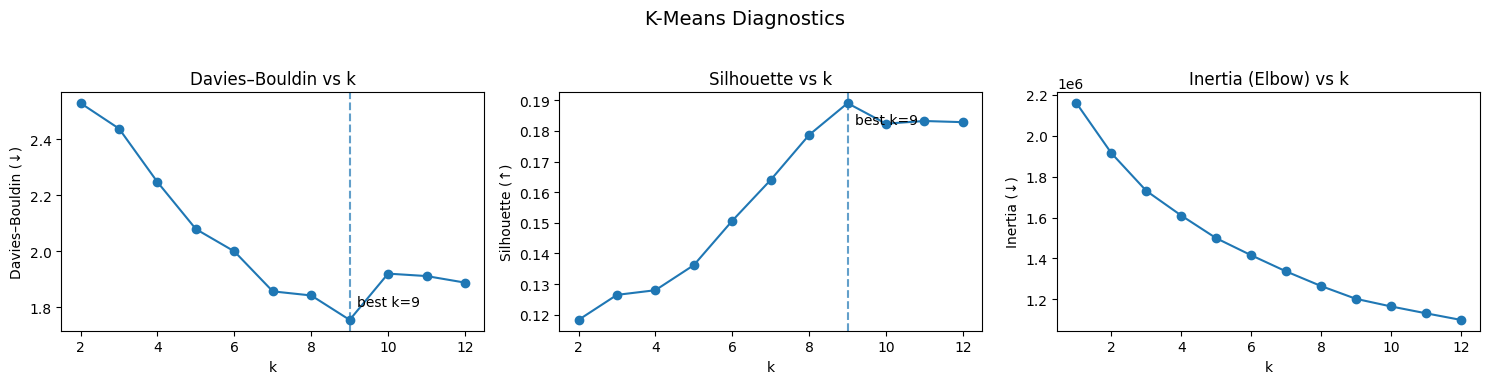

     k       inertia  silhouette  davies_bouldin
0    1  2.159057e+06         NaN             NaN
1    2  1.914620e+06    0.118328        2.528891
2    3  1.730182e+06    0.126495        2.438030
3    4  1.609622e+06    0.128015        2.247337
4    5  1.498822e+06    0.136208        2.079593
5    6  1.415489e+06    0.150688        2.000065
6    7  1.336480e+06    0.164026        1.857477
7    8  1.264988e+06    0.178709        1.842888
8    9  1.202297e+06    0.189073        1.755749
9   10  1.165256e+06    0.182385        1.920787
10  11  1.131724e+06    0.183251        1.912105
11  12  1.099376e+06    0.182873        1.888751


In [11]:
# X is your (n_samples, n_features) array
scores = plot_kmeans_diagnostics(X, k_min=1, k_max=12, title="K-Means Diagnostics")
print(scores)


for silhouette scores, maybe gradually upward.

#### Step 2: Build a helper function to examine different numbers of dimensions

Build a function to that takes a set of named transformers (in the form of an array of tuples) and then uses the previous function to evaluate k-means clustering for each.  The system should generate a row of plots for each of the transformers used.  


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def compare_kmeans_across_transformers(
    X,
    transformers,                 # list of (name, transformer) tuples; transformer can be None for identity
    k_min: int,
    k_max: int,
    base_title: str = "K-Means Diagnostics Across Transforms",
    random_state: int = 42,
    n_init: int = 10,
    max_iter: int = 300,
    row_height: float = 3.6,
    sharex: bool = True,
):
    """
    For each (name, transformer) in `transformers`, fit/transform X, evaluate K-means
    via the previously-defined plot_kmeans_diagnostics (to compute metrics), and
    render a composite figure with one *row* per transformer (DB, Silhouette, Inertia).

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    transformers : list[tuple[str, Transformer | None]]
        E.g., [("Original", None), ("PCA-2D", PCA(n_components=2)), ...]
    k_min, k_max : int
        Inclusive K range to sweep.
    base_title : str
        Figure suptitle.
    random_state, n_init, max_iter : KMeans params
    row_height : float
        Height per row (inches). Width is fixed to 15 inches.
    sharex : bool
        Whether to share the x-axis across rows.

    Returns
    -------
    scores_by_transform : dict[str, pandas.DataFrame]
        Mapping from transform name to the scores DataFrame returned by plot_kmeans_diagnostics.
    """
    import matplotlib.pyplot as plt

    n = len(transformers)
    fig, axes = plt.subplots(
        nrows=n, ncols=3, figsize=(15, max(row_height * n, row_height)),
        sharex=sharex
    )
    if n == 1:
        axes = np.array([axes])  # normalize shape to (n, 3)

    fig.suptitle(base_title, fontsize=14, y=1.02)
    scores_by_transform = {}

    for i, (name, transformer) in enumerate(transformers):
        # Transform data
        X_t = X if transformer is None else transformer.fit_transform(X)

        # Use the previous function to compute metrics (it will also create a figure)
        scores_df = plot_kmeans_diagnostics(
            X_t,
            k_min=k_min,
            k_max=k_max,
            title=f"{name}",
            random_state=random_state,
            n_init=n_init,
            max_iter=max_iter,
            figsize=(15, 4)
        )
        # Close the per-transform figure created above—we'll re-plot on our grid
        plt.close()

        scores_by_transform[name] = scores_df

        # Re-plot the three panels on our composite figure
        ax_db, ax_sil, ax_in = axes[i]

        # --- Davies–Bouldin (↓ better) ---
        ax_db.plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
        ax_db.set_title(f"{name} — Davies–Bouldin")
        ax_db.set_xlabel("k")
        ax_db.set_ylabel("DB (↓)")
        if scores_df["davies_bouldin"].notna().any():
            k_best_db = scores_df.loc[scores_df["davies_bouldin"].idxmin(), "k"]


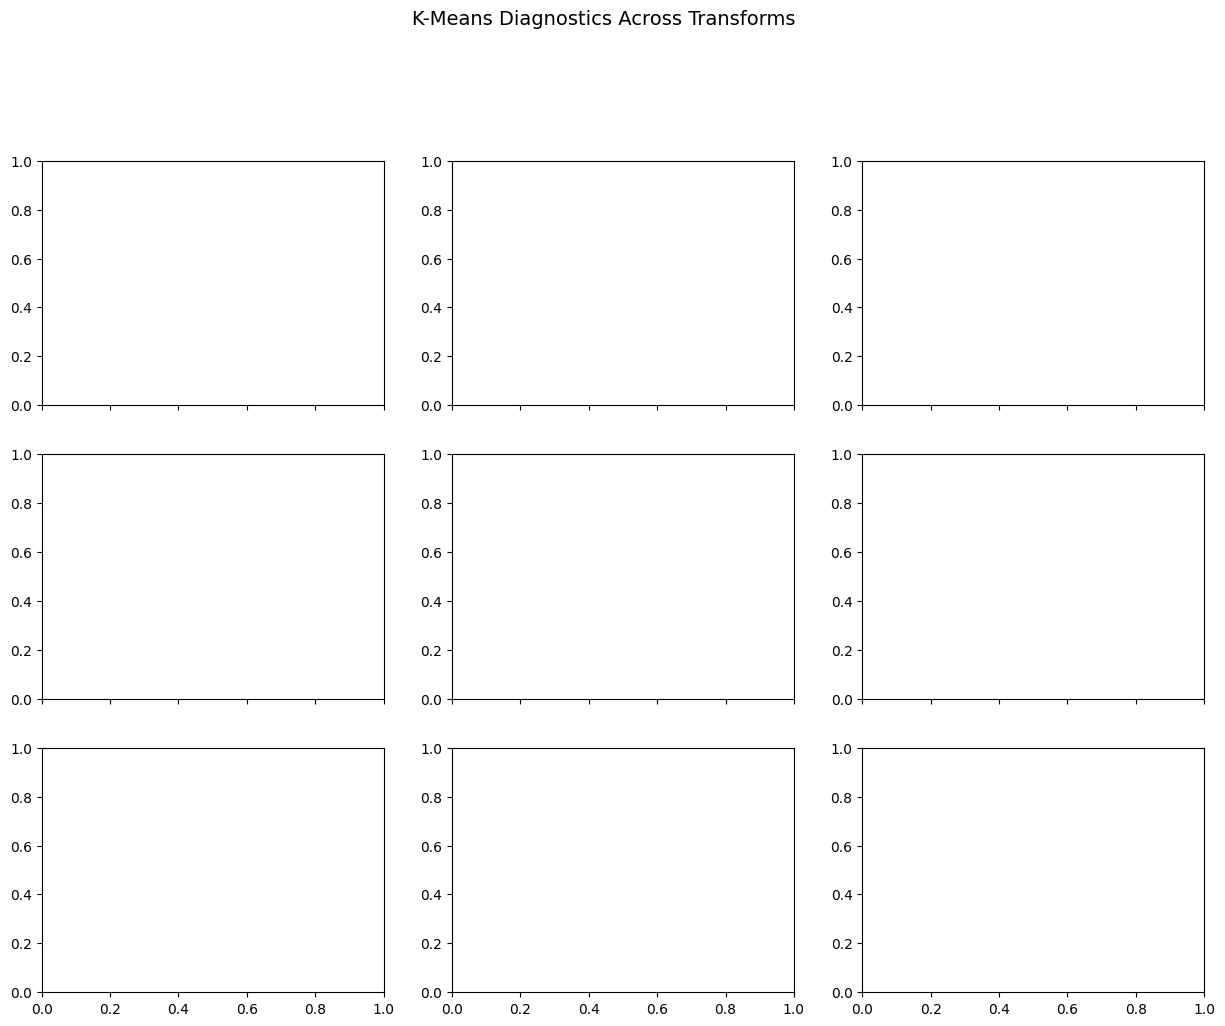

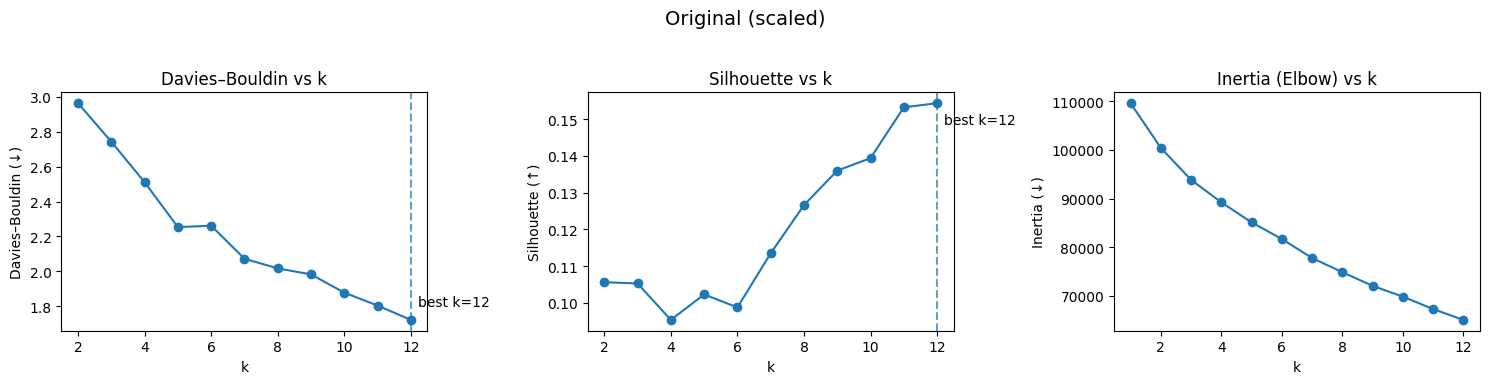

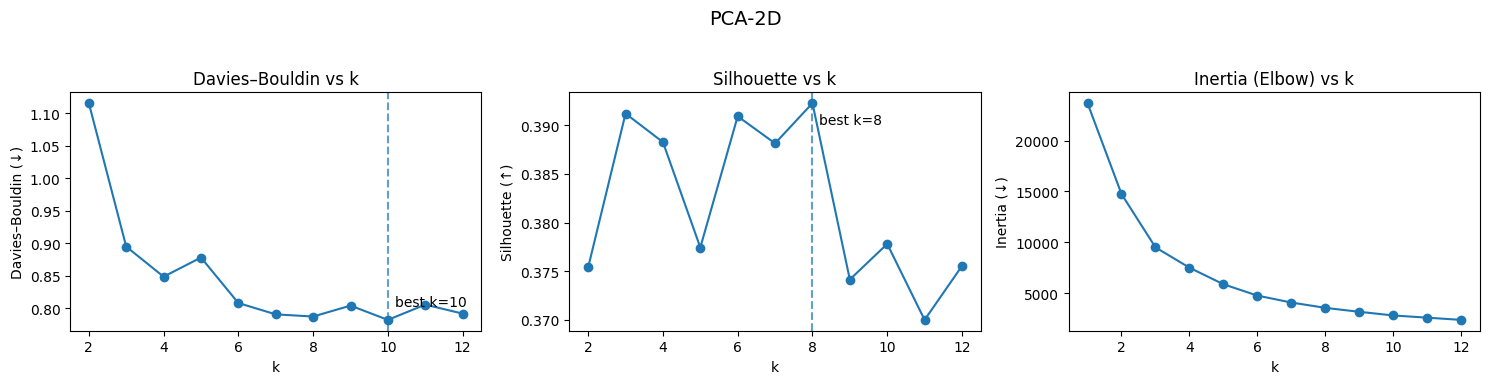

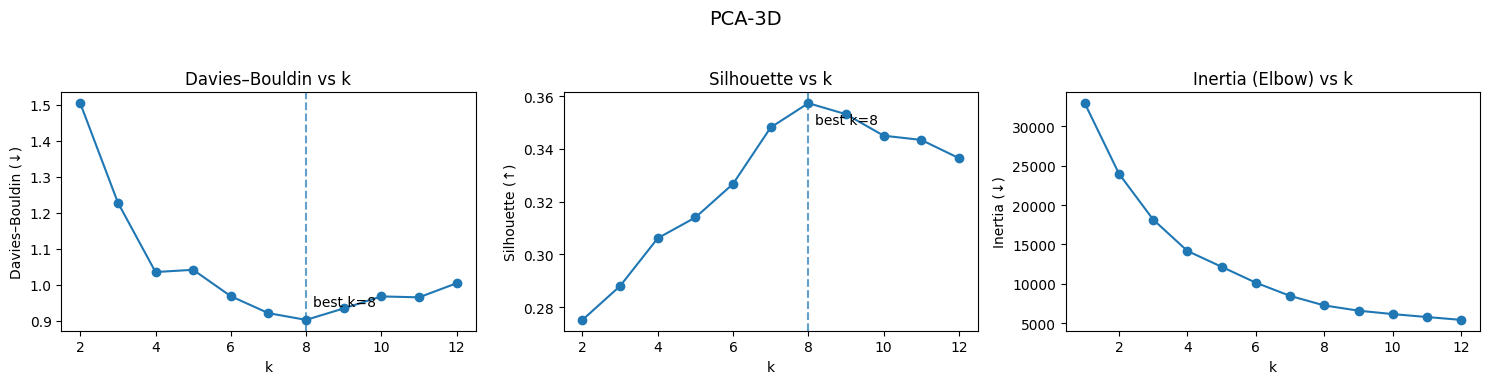

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# If you have UMAP installed:
# from umap import UMAP

X_scaled = StandardScaler().fit_transform(X)

transformers = [
    ("Original (scaled)", None),
    ("PCA-2D", PCA(n_components=2, random_state=42)),
    ("PCA-3D", PCA(n_components=3, random_state=42)),
    # ("UMAP-2D", UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)),
]

scores_by_t = compare_kmeans_across_transformers(
    X_scaled,
    transformers,
    k_min=1,
    k_max=12,
    base_title="K-Means Diagnostics Across Transforms"
)


#### Step 3: Build a simple iterator to construct the list of transformers to test

Rather than write a bunch of stuff by hand, build a simple loop that constructs 9 different transformers - 3 each for PCA, UMAP, and t-SNE - at three levels of components.  e.g., try 2, 5, and 10 dimensions. This should generate the array of transformers required by the above.

Loop through this array to evaluate the different transformers and parameters - this should give you a 9 x 3 matrix of images you can use to make decisions about which transformer method you want to use.

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def build_dimensionality_transformers(
    dims=(2, 5, 10),
    random_state: int = 42,
    pca_kwargs: dict | None = None,
    umap_kwargs: dict | None = None,
    tsne_kwargs: dict | None = None,
):
    """
    Returns a list of (name, transformer) for PCA, UMAP, and t-SNE at each dimension in `dims`.
    Requires umap-learn for UMAP; skips UMAP if not installed.
    """
    pca_kwargs = pca_kwargs or {}
    tsne_kwargs = tsne_kwargs or {}
    umap_available = True
    try:
        from umap import UMAP  # imported lazily so this file works without umap
    except Exception:
        umap_available = False

    transformers = []

    # PCA
    for d in dims:
        transformers.append((f"PCA-{d}", PCA(n_components=d, random_state=random_state, **pca_kwargs)))

    # UMAP (optional)
    if umap_available:
        default_umap = dict(n_neighbors=15, min_dist=0.1, random_state=random_state)
        default_umap.update(umap_kwargs or {})
        for d in dims:
            transformers.append((f"UMAP-{d}", UMAP(n_components=d, **default_umap)))
    else:
        print("Warning: umap-learn not installed; skipping UMAP transformers.")

    # t-SNE
    # Base defaults
    base_tsne = dict(init="pca", learning_rate="auto", perplexity=30, random_state=random_state)
    base_tsne.update(tsne_kwargs or {})

    for d in dims:
        # Barnes–Hut only supports n_components <= 3
        method = "barnes_hut" if d <= 3 else "exact"
        # Exact scales O(N^2). For very large N and d>3, consider using openTSNE/FIt-SNE instead.
        t_kwargs = {**base_tsne, "n_components": d, "method": method}
        transformers.append((f"tSNE-{d}", TSNE(**t_kwargs)))

    return transformers

In [18]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 52.6 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [umap-learn]5 [pynndescent]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


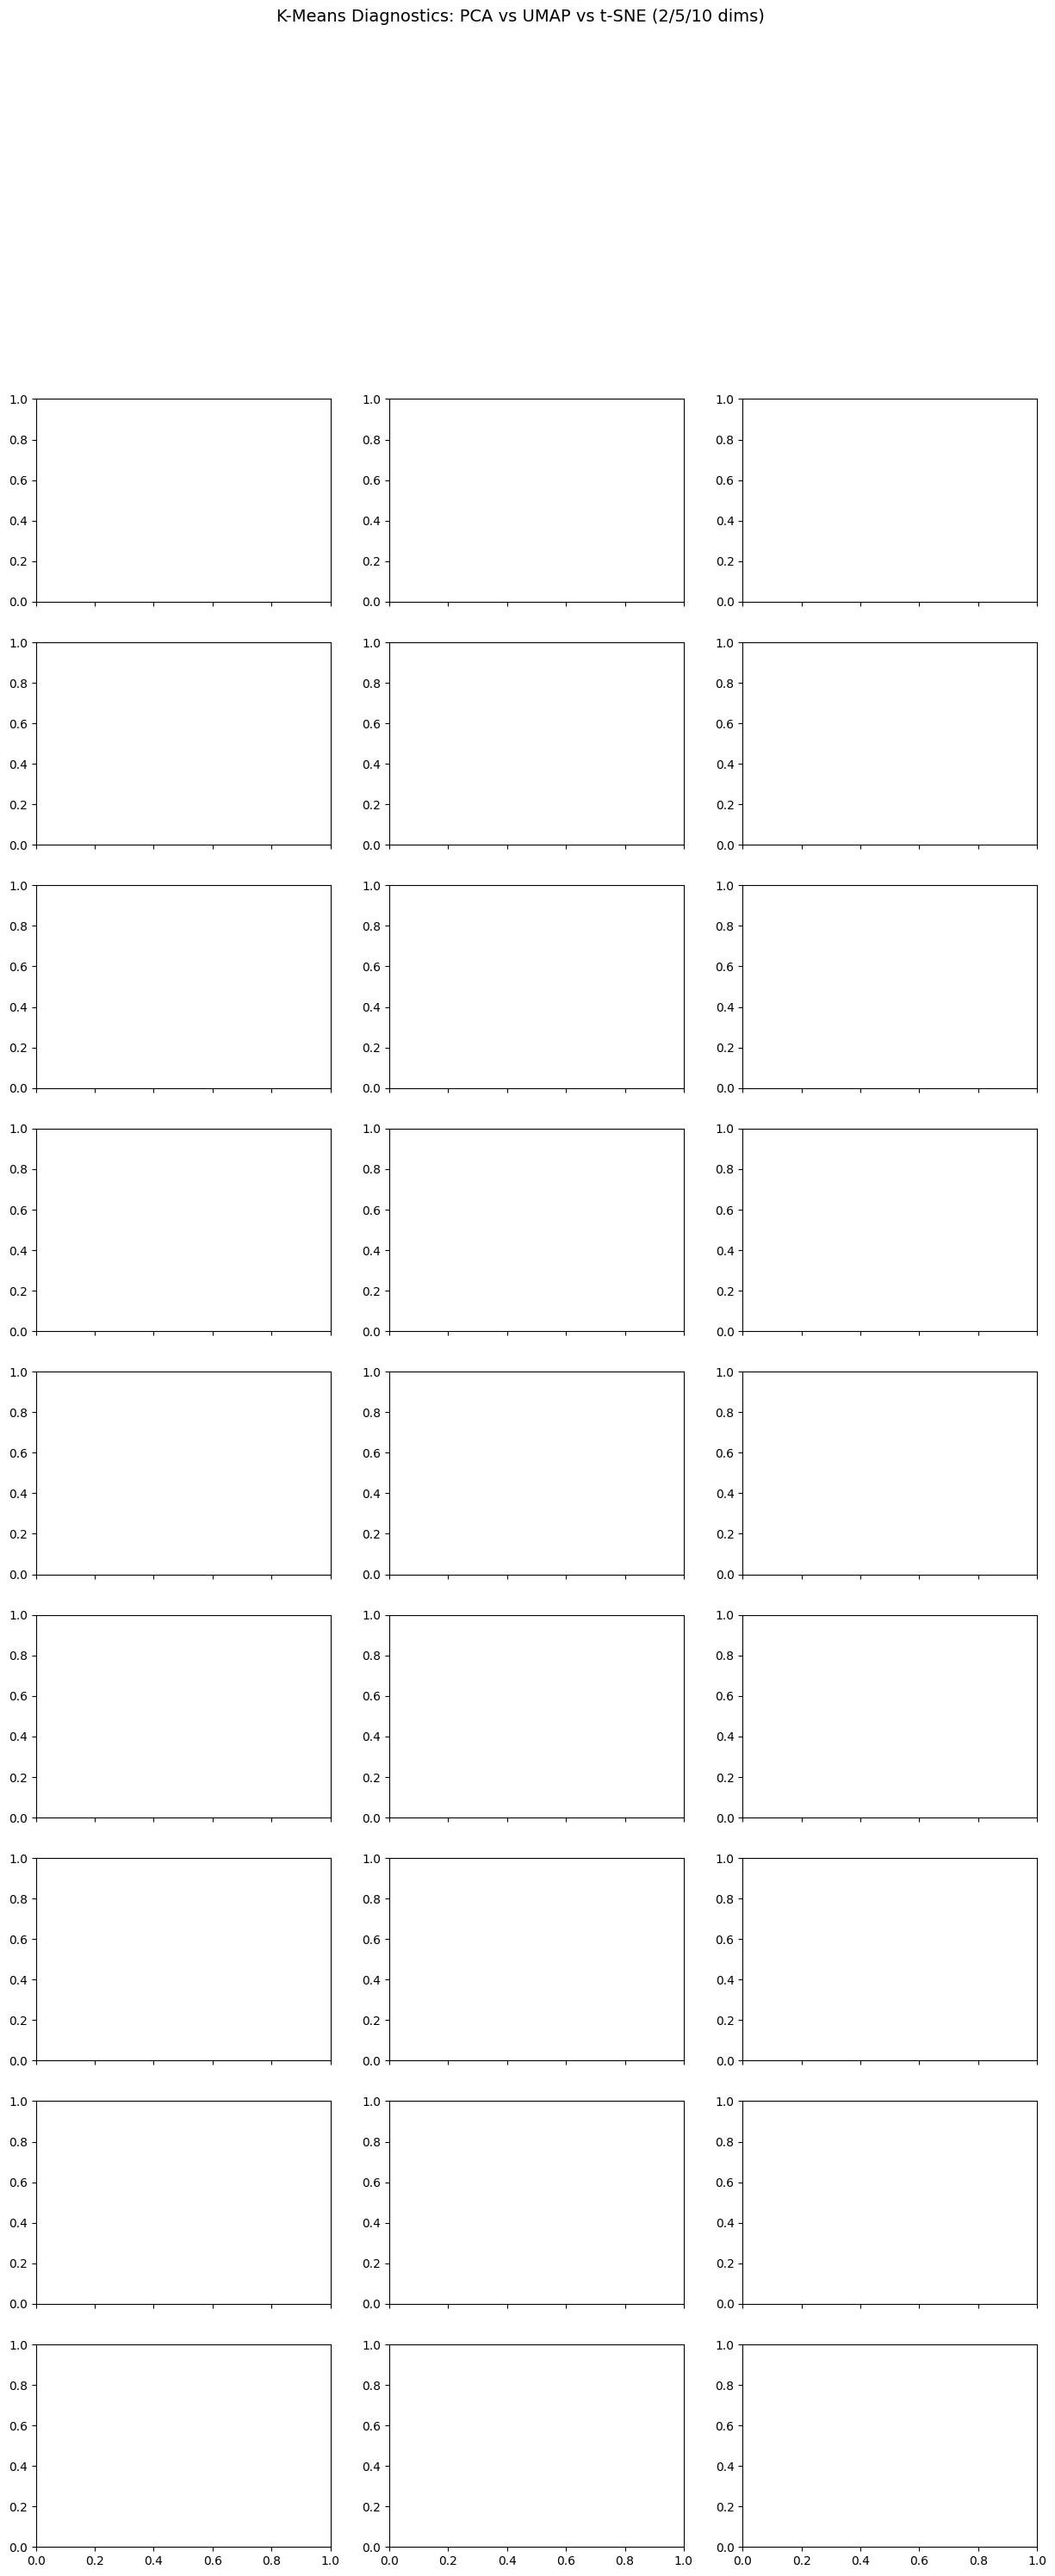

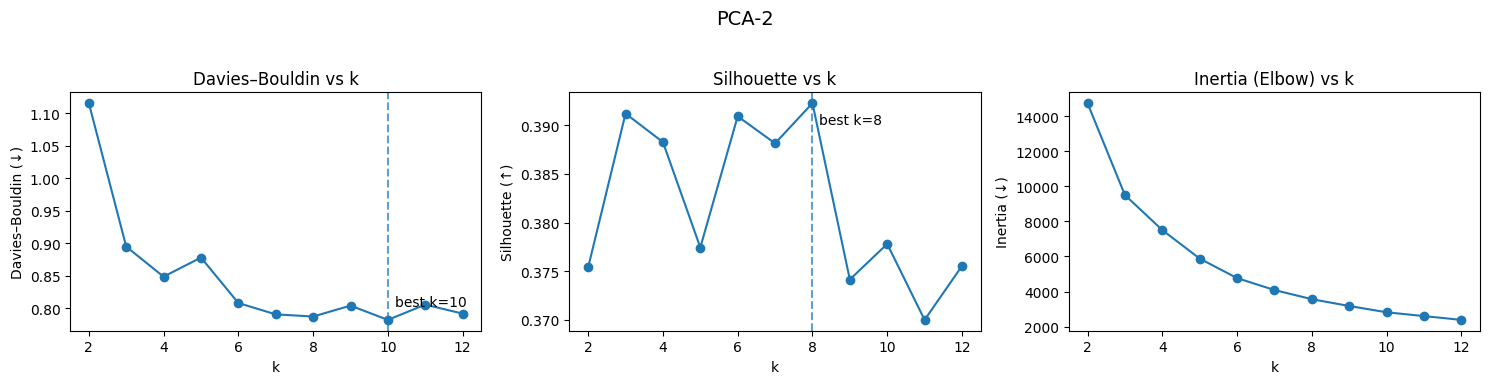

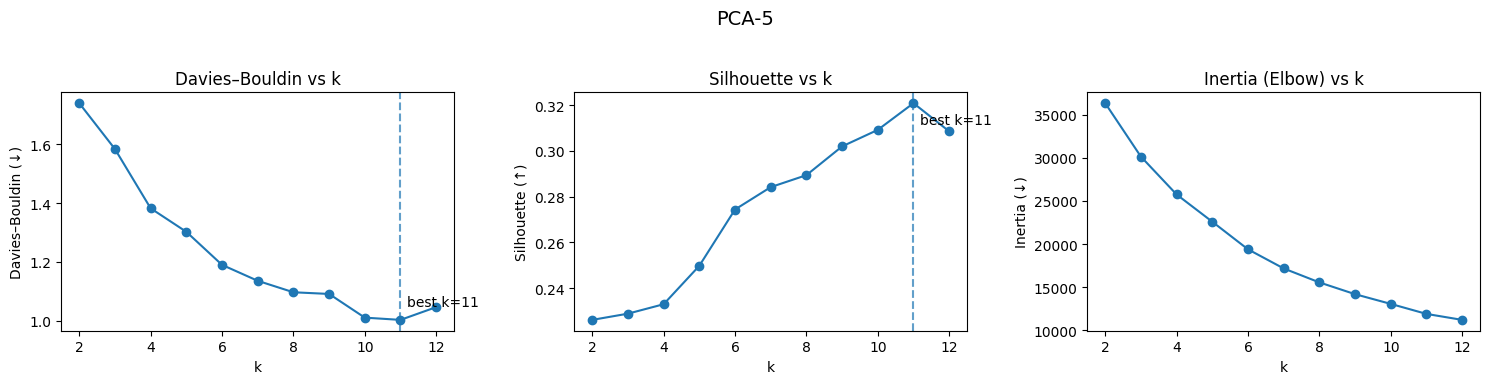

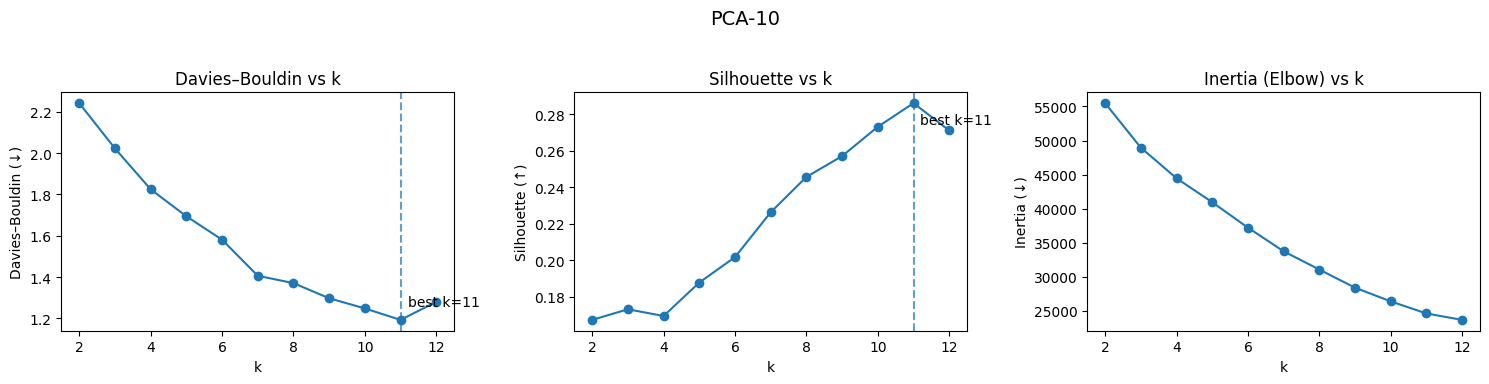

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


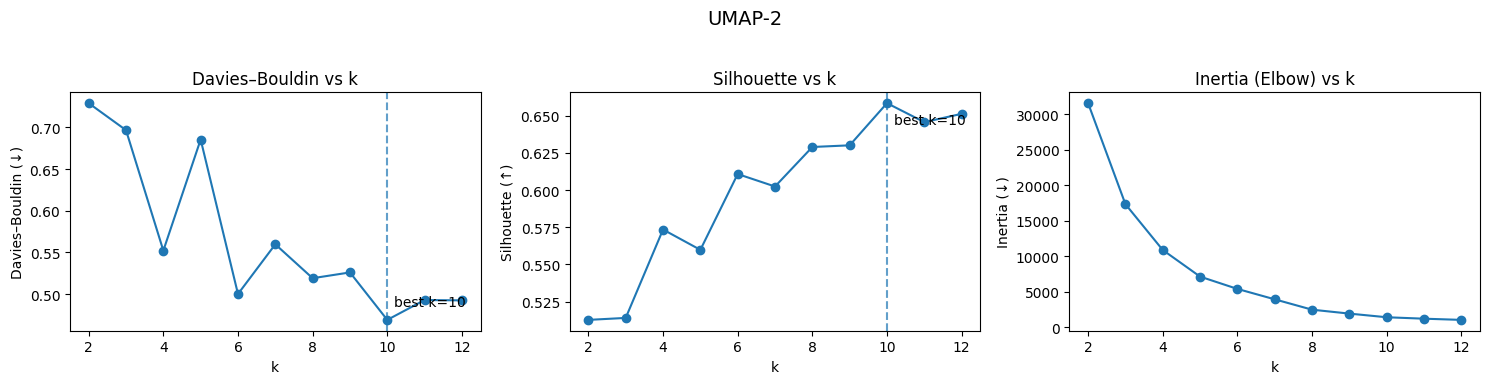

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


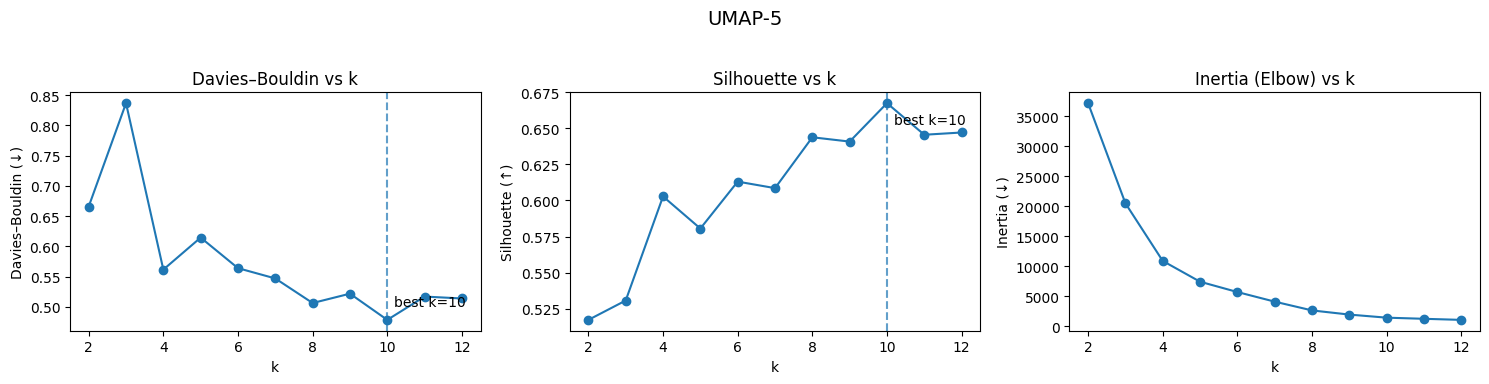

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


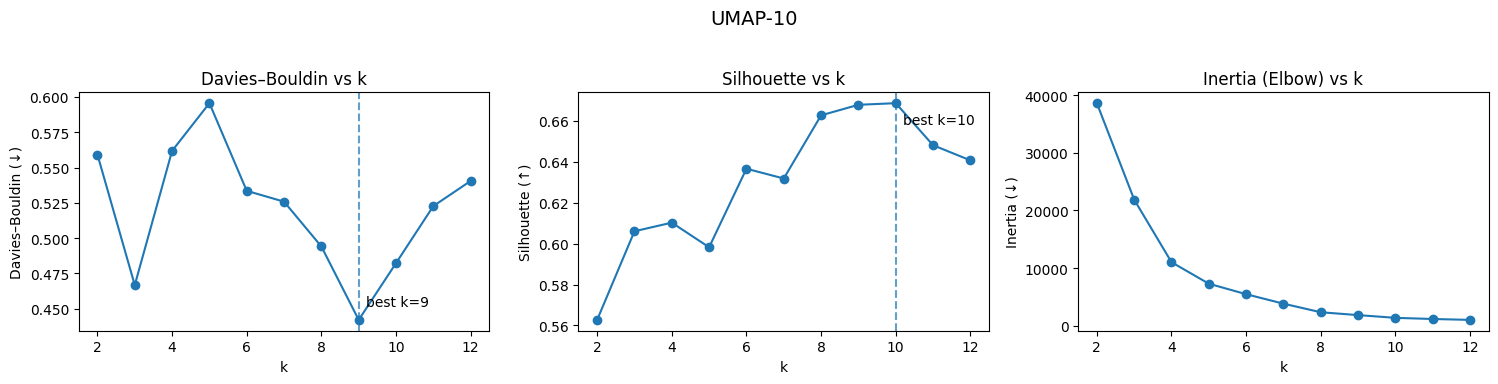

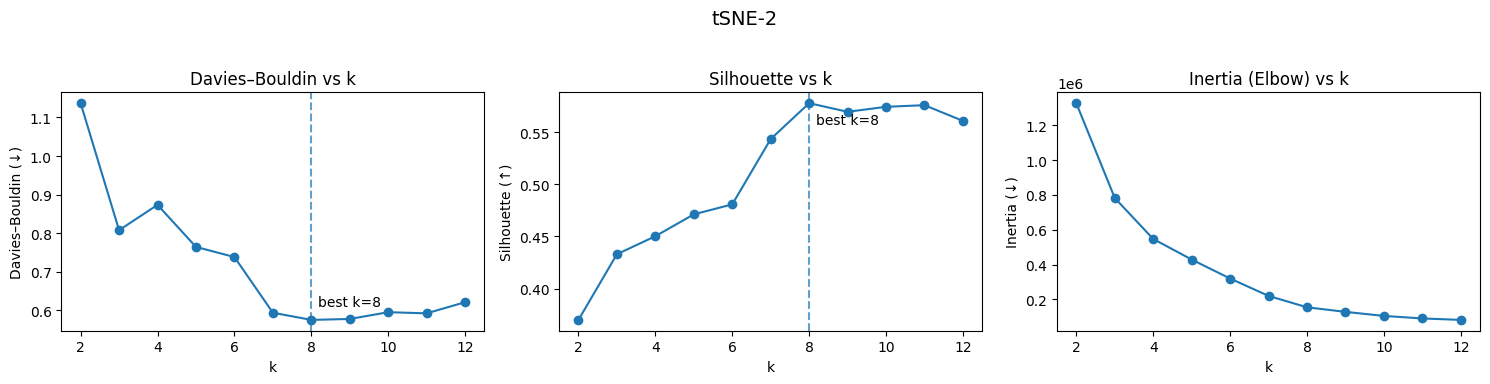

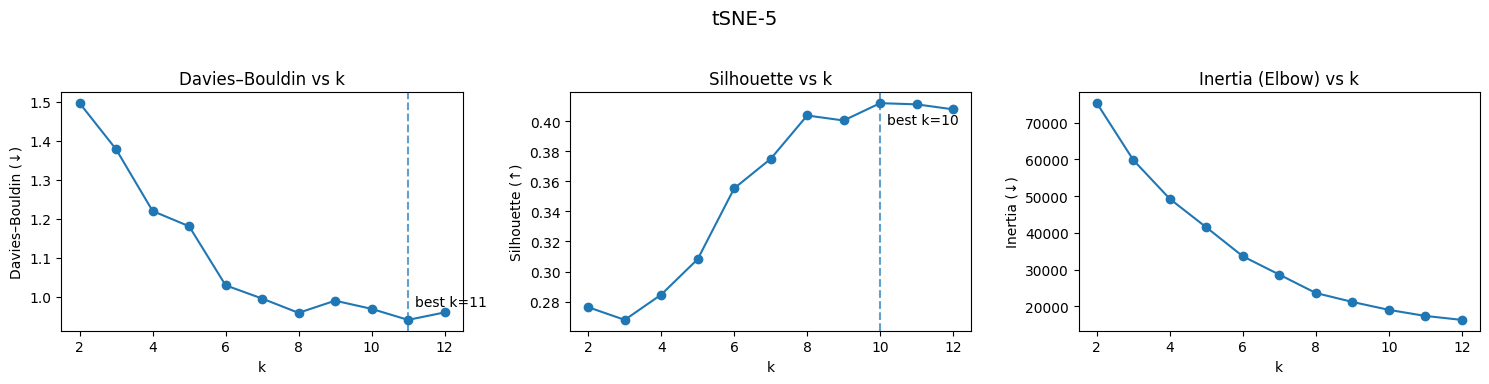

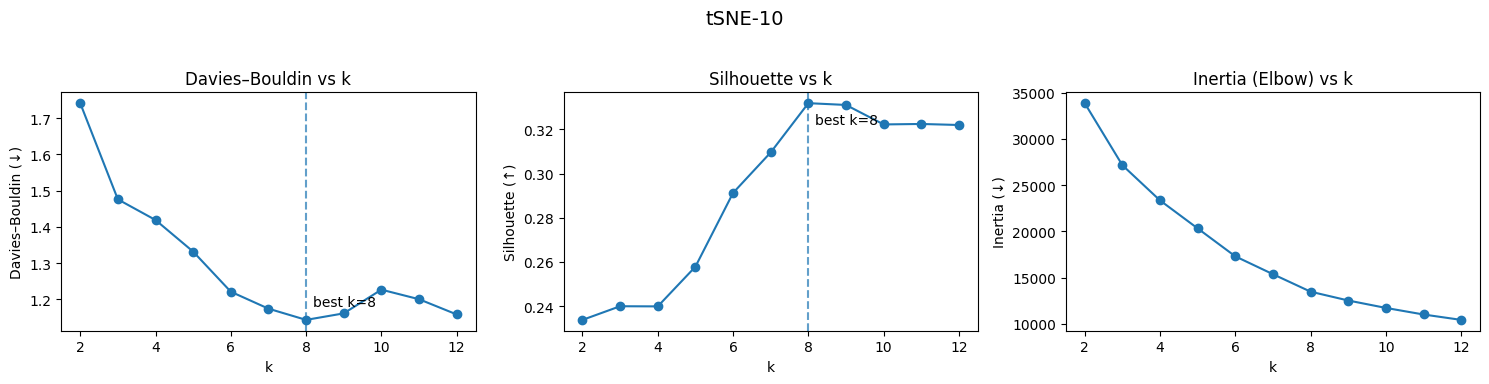

In [30]:
from sklearn.preprocessing import StandardScaler

# 1) Scale data (recommended for PCA/UMAP/KMeans)
X_scaled = StandardScaler().fit_transform(X)

# 2) Build the 9 transformers (3 × PCA/UMAP/t-SNE at dims 2,5,10)
transformers = build_dimensionality_transformers(dims=(2, 5, 10), random_state=42)

# 3) Compare across transformers using your Step-2 helper
scores_by_transform = compare_kmeans_across_transformers(
    X_scaled,
    transformers,
    k_min=2,              # start at 2 since silhouette/DB need >=2
    k_max=12,
    base_title="K-Means Diagnostics: PCA vs UMAP vs t-SNE (2/5/10 dims)",
    random_state=42,
    n_init=10,
    max_iter=300,
    row_height=3.6
)

# Optional: inspect one table of scores
# scores_by_transform["PCA-2"]


tSNE only odes low dimentional analysis. <=4 ; try to reach stablity with low dimensions as possible'


#### Step 4: Visualize your results

Build a function that allows you to pass in a transformer class, a k-value, and a set of named arguments, ground truth labels, and inferred labels and visually compare ground truth to clustered data.  That is, the function will run clustering with projection method and parameters specified.  Then it will display two plots side by side using the projection method specified (PCA, UMAP, TSNE) to see how ground truth corresponds to the inferred clusters.  Use the function to inspect your "best" methods from the above.

To make things easier, you can use the following function to build your transformer with arbitrary parameters:

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def make_transformer(transformer_cls, **kwargs):
    """Builds and returns a transformer instance with arbitrary parameters."""
    return transformer_cls(**kwargs)

def visualize_truth_vs_clusters(
    X,
    transformer_cls,
    k: int,
    transformer_kwargs: dict | None = None,
    y_true: np.ndarray | None = None,
    y_pred: np.ndarray | None = None,
    clusterer_cls=KMeans,
    clusterer_kwargs: dict | None = None,
    plot_components: int = 2,
    random_state: int = 42,
    figsize=(12, 5),
    s: float = 25.0,
    title: str = "",
):
    """
    Project X using a chosen transformer, cluster (or use provided y_pred),
    and show two plots side-by-side: colored by ground truth vs. by clusters.

    Parameters
    ----------
    X : array-like (n_samples, n_features)
    transformer_cls : class
        A class (not instance) with sklearn-like API (.fit_transform), e.g., PCA/UMAP/TSNE.
    k : int
        Number of clusters for K-Means (ignored if y_pred is provided).
    transformer_kwargs : dict
        Params for the transformer. If 'n_components' not provided, defaults to `plot_components`.
    y_true : array-like, optional
        Ground-truth labels to color the left plot and compute ARI/NMI.
    y_pred : array-like, optional
        Precomputed cluster labels. If None, will fit `clusterer_cls` on X to get labels.
    clusterer_cls : class
        Clustering class with sklearn-like API (default: KMeans).
    clusterer_kwargs : dict
        Params for the clusterer. If None, uses sensible defaults for KMeans.
    plot_components : int
        Dimensionality of the projection used for visualization (typically 2).
    random_state : int
        Passed to transformer/clusterer when supported.
    figsize : tuple
        Size of the matplotlib figure.
    s : float
        Marker size for scatter plots.
    title : str
        Suptitle for the figure.

    Returns
    -------
    proj : np.ndarray of shape (n_samples, plot_components)
        The projected coordinates used for visualization.
    labels : np.ndarray
        The cluster labels used in the right-hand plot.
    scores : dict
        {'ARI': ..., 'NMI': ...} if y_true is provided, else {}.
    """
    transformer_kwargs = dict(transformer_kwargs or {})
    clusterer_kwargs = dict(clusterer_kwargs or {})

    # Ensure projection dimensionality is set
    transformer_kwargs.setdefault("n_components", plot_components)
    # For t-SNE >3D, scikit-learn needs method='exact' (Barnes–Hut supports ≤3)
    # If user passes TSNE and asks for >3, they should set method='exact' in transformer_kwargs.

    # Some transformers accept random_state; set it if available and not already provided
    if "random_state" not in transformer_kwargs:
        transformer_kwargs["random_state"] = random_state

    transformer = make_transformer(transformer_cls, **transformer_kwargs)
    proj = transformer.fit_transform(X)

    # Cluster (unless labels already provided)
    if y_pred is None:
        if clusterer_cls is KMeans:
            clusterer_kwargs.setdefault("n_clusters", k)
            clusterer_kwargs.setdefault("n_init", 10)
            clusterer_kwargs.setdefault("max_iter", 300)
            clusterer_kwargs.setdefault("random_state", random_state)
        labels = clusterer_cls(**clusterer_kwargs).fit_predict(X)
    else:
        labels = np.asarray(y_pred)

    # Compute agreement metrics if ground truth is available
    scores = {}
    if y_true is not None:
        scores["ARI"] = adjusted_rand_score(y_true, labels)
        scores["NMI"] = normalized_mutual_info_score(y_true, labels)

    # --- Plots ---
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    if title:
        fig.suptitle(title, fontsize=14)

    # Left: Ground truth
    ax = axes[0]
    if y_true is not None:
        sc0 = ax.scatter(proj[:, 0], proj[:, 1], c=y_true, s=s)
        ax.set_title("Projection colored by Ground Truth")
    else:
        sc0 = ax.scatter(proj[:, 0], proj[:, 1], s=s, alpha=0.8)
        ax.set_title("Projection (no ground truth provided)")
    ax.set_xlabel("Comp 1")
    ax.set_ylabel("Comp 2")

    # Right: Cluster assignments
    ax = axes[1]
    sc1 = ax.scatter(proj[:, 0], proj[:, 1], c=labels, s=s)
    right_title = "Projection colored by K-Means clusters"
    if scores:
        right_title += f"\nARI={scores['ARI']:.3f} | NMI={scores['NMI']:.3f}"
    ax.set_title(right_title)
    ax.set_xlabel("Comp 1")
    ax.set_ylabel("Comp 2")

    plt.tight_layout()
    plt.show()

    return proj, labels, scores


In [31]:
def new_transformer(cls, **kwargs):
    """
    Given a class (e.g. PCA) and kwargs, return a new instance.
    Example:
        t = new_transformer(PCA, n_components=2)
    """
    return cls(**kwargs)

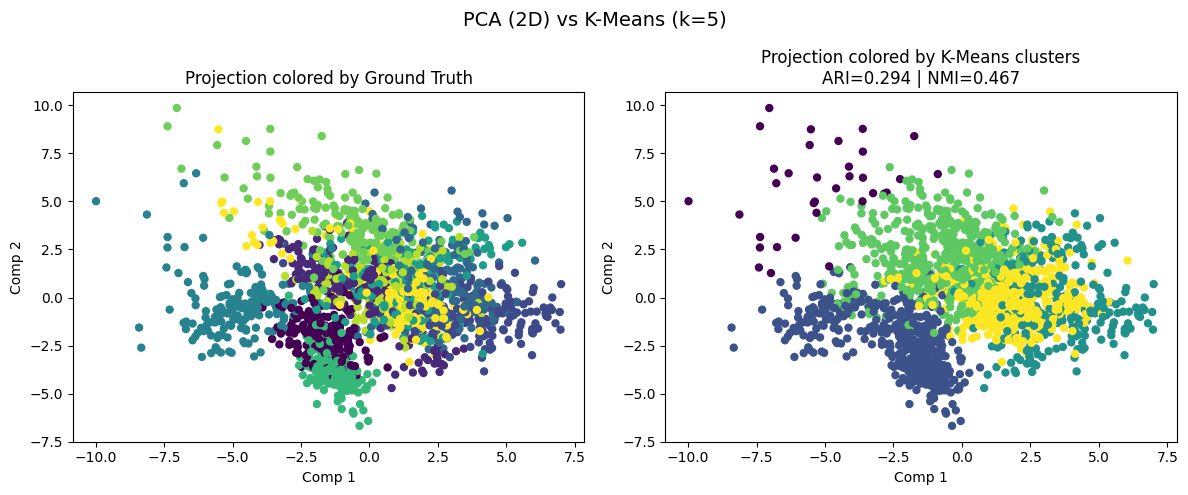

NameError: name 'UMAP' is not defined

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# UMAP (requires `pip install umap-learn`)
# from umap import UMAP
# t-SNE
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X)

# 1) PCA, k from your earlier diagnostics
proj, labels, scores = visualize_truth_vs_clusters(
    X_scaled,
    transformer_cls=PCA,
    k=5,
    transformer_kwargs={"n_components": 2},
    y_true=y,                # optional
    title="PCA (2D) vs K-Means (k=5)"
)

# 2) UMAP (2D)
proj, labels, scores = visualize_truth_vs_clusters(
    X_scaled,
     transformer_cls=UMAP,
     k=5,
     transformer_kwargs={"n_components": 2, "n_neighbors": 15, "min_dist": 0.1},
     y_true=y,
     title="UMAP (2D) vs K-Means (k=5)"
 )

# 3) t-SNE (2D)
proj, labels, scores = visualize_truth_vs_clusters(
    X_scaled,
    transformer_cls=TSNE,
    k=5,
    transformer_kwargs={"n_components": 2, "init": "pca", "learning_rate": "auto", "perplexity": 30},
    y_true=y,
    title="t-SNE (2D) vs K-Means (k=5)"
)


### Exercise 2

Using any one of the projected versions of MNIST handwriting data above, use the HAC method with different linkages and different cutoff levels to understand how the identified clusters vary over both of these hyper-parameters.  How does HAC compare with K-Means?  Which linkage do you prefer and why? 